In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy.optimize import minimize
from numba import njit
from typing import Tuple, Optional
from enum import Enum

# import qis
from dataclasses import fields, replace, asdict
import pickle
from statsmodels.api import OLS, GLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy

# analytics
import sys
sys.path.insert(0, '../../') # just for jupyter  notebook
from stochvolmodels.pricers.hawkes_jd_pricer import HawkesJDParams, HawkesJDPricer, hawkesjd_chain_pricer, unpack_and_transform_pars_for_measure_change, unpack_pars
from stochvolmodels.data.option_chain import OptionChain

import tensorflow.experimental.numpy as tnp
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from stochvolmodels.data.test_option_chain import get_btc_test_chain_data
from stochvolmodels.utils.funcs import to_flat_np_array, set_time_grid, timer, set_seed, transform_to_tfcomplex128, transform_from_tfcomplex128_to_np, slice_option_chain
import copy
from stochvolmodels.MLE_estimator import hawkes_jd

import warnings
warnings.filterwarnings('ignore')

2024-01-26 20:39:35.324172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
P_params = pd.read_csv('P_params.csv', index_col=0)
P_params.index = pd.Series(P_params.index).apply(lambda x: x[:10])
P_params.index = pd.to_datetime(P_params.index)

with open("Q_results_refined.pickle", "rb") as f: 
    Q_results = pickle.load(f)
    
Q_params = dict()
for date in Q_results:
    d = asdict(transform_from_tfcomplex128_to_np(Q_results[date]['measure_change_results']))
    
    d['is_pos_jump'] = Q_results[date]['is_pos_jump']
    d['is_neg_jump'] = Q_results[date]['is_neg_jump']
    
    if Q_results[date]['MAPE'] <= 2:
        Q_params[date] = d
    
Q_params = pd.DataFrame(Q_params).T
Q_params.index = pd.to_datetime(Q_params.index)
Q_params = Q_params.astype(np.float64)

In [3]:
nu_m = P_params.nu_m.iloc[0]
nu_p = P_params.nu_p.iloc[0]

In [4]:
theta_p = P_params.loc[:,'theta_p'].iloc[0]
theta_m = P_params.loc[:,'theta_m'].iloc[0]
kappa_p = P_params.loc[:,'kappa_p'].iloc[0]
kappa_m = P_params.loc[:,'kappa_m'].iloc[0]
beta11  = P_params.loc[:,'beta11'].iloc[0]
beta12  = P_params.loc[:,'beta12'].iloc[0]
beta21  = P_params.loc[:,'beta21'].iloc[0]
beta22  = P_params.loc[:,'beta22'].iloc[0]
eta_p   = P_params.loc[:,'eta_p'].iloc[0]
eta_m   = P_params.loc[:,'eta_m'].iloc[0]
nu_p    = P_params.loc[:,'nu_p'].iloc[0]
nu_m    = P_params.loc[:,'nu_m'].iloc[0]

mu = 0
sigma = P_params.sigma.iloc[0]

lambda_p = P_params.lambda_p_right.iloc[-1]
lambda_m = P_params.lambda_m_right.iloc[-1]

In [5]:
SECONDS_PER_YEAR = 365 * 24 * 60 * 60  # minute, seconds

In [6]:
array = np.array

In [7]:
N_options_ttm = 40
Moneyness_range = (0.6,1.4)

ids = array(['2w', '1m', '2m', '3m'])
ticker = 'BTC'
ttms = array([14/365, 1/12, 2/12, 3/12])
forwards = array([10_000, 10_000, 10_000, 10_000])
discfactors = array([1.0, 1.0, 1.0, 1.0])
bid_ivs = tuple([(array([0]*N_options_ttm)) for _ in range(4)])
ask_ivs = tuple([(array([0]*N_options_ttm)) for _ in range(4)])

strikes_ttms = tuple([10_000*(np.linspace(Moneyness_range[0], Moneyness_range[1], int(N_options_ttm))) for _ in range(4)])

optiontypes_ttms = tuple([array(['P']*int(N_options_ttm/2) + ['C']*int(N_options_ttm/2) , dtype='<U1') for _ in range(4)])

option_chain = OptionChain(ids=ids,
                    ttms=ttms,
                    ticker=ticker,
                    forwards=forwards,
                    strikes_ttms=strikes_ttms,
                    optiontypes_ttms=optiontypes_ttms,
                    discfactors=discfactors,
                    bid_ivs=bid_ivs,
                    ask_ivs=ask_ivs)

In [8]:
optiontypes_ttms[0].shape

(40,)

In [9]:
params = HawkesJDParams(mu=mu, sigma=sigma,
                        eta_p=eta_p, nu_p=nu_p, eta_m=eta_m, nu_m=nu_m,
                        theta_p=theta_p, kappa_p=kappa_p, theta_m=theta_m, kappa_m=kappa_m,
                        beta11=beta11, beta21=beta21, beta12=beta12, beta22=beta22,
                        lambda_p=lambda_p, lambda_m=lambda_m)

params = transform_to_tfcomplex128(params)

In [10]:
pricer = HawkesJDPricer(M=2**11, x_max=12, n_steps_per_ttm=100)
model_ivs_ttms = pricer.compute_model_ivols_for_chain(option_chain=option_chain, params=params)

In [11]:
def gen_transofrmed_params(targets, params):
    pjp_target, njp_target = targets

    def loss(chis):
        chi_p, chi_m = chis
        transformed_params = unpack_and_transform_pars_for_measure_change((sigma, chi_p, chi_m), params)[1]
        pjp = transformed_params.lambda_p * transformed_params.compensator_p - params.lambda_p * params.compensator_p
        njp = transformed_params.lambda_m * transformed_params.compensator_m - params.lambda_m * params.compensator_m
        
        pjp = pjp.numpy().real
        njp = njp.numpy().real

        return (pjp-pjp_target)**2 + (njp-njp_target)**2

    result = scipy.optimize.fmin(loss, (0, 0))

    transformed_params = unpack_and_transform_pars_for_measure_change((sigma, result[0], result[1]), params)[1]
    
    return transformed_params


In [12]:
pricer = HawkesJDPricer(M=2**11, x_max=12, n_steps_per_ttm=100)

In [13]:
transformed_params_pjp = dict()

for pjp in np.linspace(-1, 1, 21):
    transformed_params = gen_transofrmed_params((pjp, 0), params)
    transformed_params_pjp[pjp] = transformed_params

transformed_params_njp = dict()

for njp in np.linspace(-1, 1, 21):
    transformed_params = gen_transofrmed_params((0, njp), params)
    transformed_params_njp[njp] = transformed_params


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 76
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 81
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 72
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 72
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 67
         Function evaluations: 134
Optimization terminated suc

In [14]:
model_ivs_ttms_pjp = dict()
for pjp in transformed_params_pjp:
    model_ivs_ttms = pricer.compute_model_ivols_for_chain(option_chain=option_chain, params=transformed_params_pjp[pjp])
    model_ivs_ttms_pjp[pjp] = model_ivs_ttms

model_ivs_ttms_njp = dict()
for njp in transformed_params_njp:
    model_ivs_ttms = pricer.compute_model_ivols_for_chain(option_chain=option_chain, params=transformed_params_njp[njp])
    model_ivs_ttms_njp[njp] = model_ivs_ttms

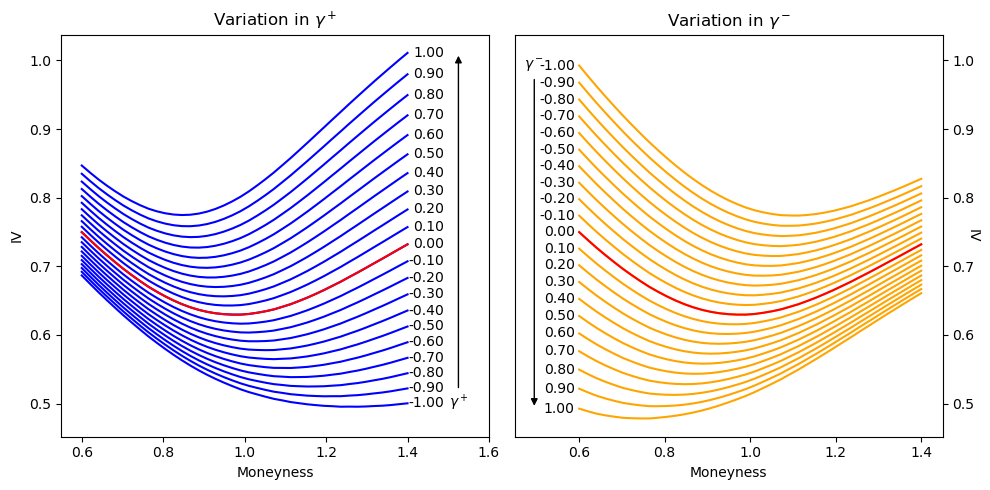

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=False, sharey=True)

model_ivs_ttms = pricer.compute_model_ivols_for_chain(option_chain=option_chain, params=params)
ax[0].plot(option_chain.strikes_ttms[1]/option_chain.forwards[0], model_ivs_ttms[1], 'red', zorder=10)
ax[1].plot(option_chain.strikes_ttms[1]/option_chain.forwards[0], model_ivs_ttms[1], 'red', zorder=10)

y1 = np.float(model_ivs_ttms_pjp[-1.0][1][-1])
y2 = np.float(model_ivs_ttms_pjp[1.0][1][-1])
ax[0].annotate(r'$\gamma^+$', xytext=(1.525, y1) , xy=(1.525, y2),
                        ha='center',va='center',
                        arrowprops=dict(arrowstyle= '-|>',
                        color='black',
                        lw=1,
                        ls='-'), zorder=100)

y1 = np.float(model_ivs_ttms_njp[-1.0][1][0])
y2 = np.float(model_ivs_ttms_njp[1.0][1][0])
ax[1].annotate(r'$\gamma^-$', xytext=(.495, y1) , xy=(.495, y2),
                        ha='center',va='center',
                        arrowprops=dict(arrowstyle= '-|>',
                        color='black',
                        lw=1,
                        ls='-'), zorder=100)


for pjp in transformed_params_pjp:
    model_ivs_ttms = model_ivs_ttms_pjp[pjp]
    ax[0].plot(option_chain.strikes_ttms[1]/option_chain.forwards[0], model_ivs_ttms[1], 'blue')
    ax[0].annotate(text='%.2f'%pjp,
                   xy=( (option_chain.strikes_ttms[1]/option_chain.forwards[0])[-1]+0.09, model_ivs_ttms[1][-1] ), 
                   ha='right', va='center')



for njp in transformed_params_njp:
    model_ivs_ttms = model_ivs_ttms_njp[njp]
    ax[1].plot(option_chain.strikes_ttms[1]/option_chain.forwards[0], model_ivs_ttms[1], 'orange')
    ax[1].annotate(text='%.2f'%njp,
                   xy=( (option_chain.strikes_ttms[1]/option_chain.forwards[0])[0]-0.01, model_ivs_ttms[1][0] ), 
                   ha='right', va='center')
    

ax[0].set_xlim((0.55,1.6))
ax[1].set_xlim((0.45,1.45))

ax[0].set_xlabel('Moneyness')
ax[1].set_xlabel('Moneyness')
ax[0].set_ylabel('IV')


ax[1].yaxis.set_ticks_position('right')
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel('IV', rotation=270)

ax[0].set_title(r'Variation in $\gamma^+$')
ax[1].set_title(r'Variation in $\gamma^-$')

plt.tight_layout()
plt.savefig('IV_smiles_varying_gammas.pdf', transparent=True)

In [16]:
params = HawkesJDParams(mu=mu, sigma=sigma,
                        eta_p=eta_p, nu_p=nu_p, eta_m=eta_m, nu_m=nu_m,
                        theta_p=theta_p, kappa_p=kappa_p, theta_m=theta_m, kappa_m=kappa_m,
                        beta11=beta11, beta21=0, beta12=0, beta22=beta22,
                        lambda_p=lambda_p, lambda_m=lambda_m)

params = transform_to_tfcomplex128(params)

In [17]:
transformed_params_pjp = dict()

for pjp in np.linspace(-1, 1, 21):
    transformed_params = gen_transofrmed_params((pjp, 0), params)
    transformed_params_pjp[pjp] = transformed_params

transformed_params_njp = dict()

for njp in np.linspace(-1, 1, 21):
    transformed_params = gen_transofrmed_params((0, njp), params)
    transformed_params_njp[njp] = transformed_params

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 76
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 81
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 74
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 72
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 72
         Function evaluations: 140
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 75
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 67
         Function evaluations: 134
Optimization terminated suc

In [18]:
model_ivs_ttms_pjp = dict()
for pjp in transformed_params_pjp:
    model_ivs_ttms = pricer.compute_model_ivols_for_chain(option_chain=option_chain, params=transformed_params_pjp[pjp])
    model_ivs_ttms_pjp[pjp] = model_ivs_ttms

model_ivs_ttms_njp = dict()
for njp in transformed_params_njp:
    model_ivs_ttms = pricer.compute_model_ivols_for_chain(option_chain=option_chain, params=transformed_params_njp[njp])
    model_ivs_ttms_njp[njp] = model_ivs_ttms

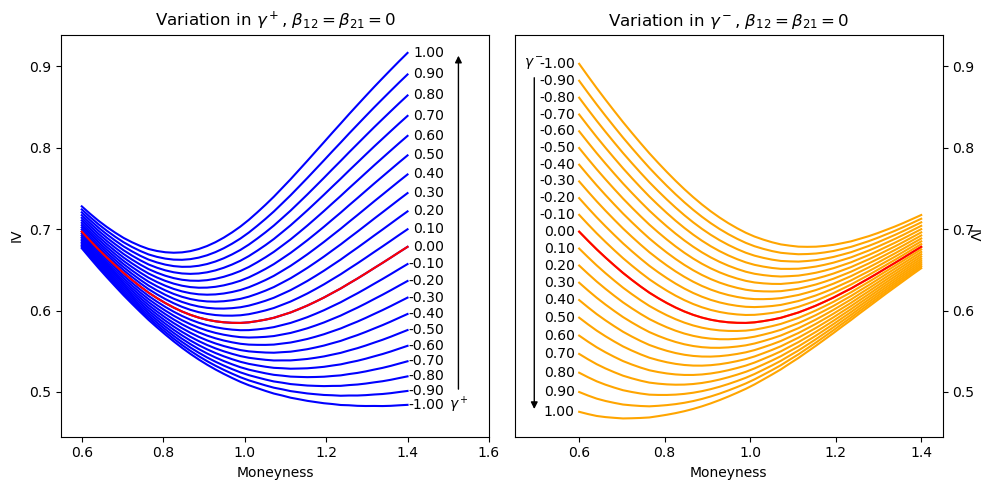

In [19]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=False, sharey=True)

model_ivs_ttms = pricer.compute_model_ivols_for_chain(option_chain=option_chain, params=params)
ax[0].plot(option_chain.strikes_ttms[1]/option_chain.forwards[0], model_ivs_ttms[1], 'red', zorder=10)
ax[1].plot(option_chain.strikes_ttms[1]/option_chain.forwards[0], model_ivs_ttms[1], 'red', zorder=10)

y1 = np.float(model_ivs_ttms_pjp[-1.0][1][-1])
y2 = np.float(model_ivs_ttms_pjp[1.0][1][-1])
ax[0].annotate(r'$\gamma^+$', xytext=(1.525, y1) , xy=(1.525, y2),
                        ha='center',va='center',
                        arrowprops=dict(arrowstyle= '-|>',
                        color='black',
                        lw=1,
                        ls='-'), zorder=100)

y1 = np.float(model_ivs_ttms_njp[-1.0][1][0])
y2 = np.float(model_ivs_ttms_njp[1.0][1][0])
ax[1].annotate(r'$\gamma^-$', xytext=(.495, y1) , xy=(.495, y2),
                        ha='center',va='center',
                        arrowprops=dict(arrowstyle= '-|>',
                        color='black',
                        lw=1,
                        ls='-'), zorder=100)


for pjp in transformed_params_pjp:
    model_ivs_ttms = model_ivs_ttms_pjp[pjp]
    ax[0].plot(option_chain.strikes_ttms[1]/option_chain.forwards[0], model_ivs_ttms[1], 'blue')
    ax[0].annotate(text='%.2f'%pjp,
                   xy=( (option_chain.strikes_ttms[1]/option_chain.forwards[0])[-1]+0.09, model_ivs_ttms[1][-1] ), 
                   ha='right', va='center')



for njp in transformed_params_njp:
    model_ivs_ttms = model_ivs_ttms_njp[njp]
    ax[1].plot(option_chain.strikes_ttms[1]/option_chain.forwards[0], model_ivs_ttms[1], 'orange')
    ax[1].annotate(text='%.2f'%njp,
                   xy=( (option_chain.strikes_ttms[1]/option_chain.forwards[0])[0]-0.01, model_ivs_ttms[1][0] ), 
                   ha='right', va='center')
    

ax[0].set_xlim((0.55,1.6))
ax[1].set_xlim((0.45,1.45))
ax[0].set_xlabel('Moneyness')
ax[1].set_xlabel('Moneyness')
ax[0].set_ylabel('IV')


ax[1].yaxis.set_ticks_position('right')
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel('IV', rotation=270)

ax[0].set_title(r'Variation in $\gamma^+$, $\beta_{12}=\beta_{21}=0$')
ax[1].set_title(r'Variation in $\gamma^-$, $\beta_{12}=\beta_{21}=0$')

plt.tight_layout()

plt.savefig('IV_smiles_varying_gammas_muted_offdiagonal_betas.pdf', transparent=True)